
## 1. Introduction
Our dataset is a list of housing listings from the top 45 most populous cities in canada. We felt that it would be interesting and relevant (since we are first years looking for housing) to study this data and identify patterns in it. Our goal is to create a regression model that can predict price using number of beds, number of baths, and median income as predictors.

## 2. Tidying and Wrangling

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

We load our data into a tibble:

In [6]:
housing_raw <- read_csv("data/HouseListings-Top45Cities-10292023-kaggle.csv") |> clean_names()
housing_raw

Rows: 35768 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): City, Address, Province
dbl (7): Price, Number_Beds, Number_Baths, Population, Latitude, Longitude, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


city,price,address,number_beds,number_baths,province,population,latitude,longitude,median_family_income
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Toronto,779900,#318 -20 SOUTHPORT ST,3,2,Ontario,5647656,43.7417,-79.3733,97000
Toronto,799999,#818 -60 SOUTHPORT ST,3,1,Ontario,5647656,43.7417,-79.3733,97000
Toronto,799900,#714 -859 THE QUEENSWAY,2,2,Ontario,5647656,43.7417,-79.3733,97000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Halifax,419900,212 60 Walter Havill Drive,2,2,Nova Scotia,431479,44.8857,63.1005,86753
Halifax,949900,10 Idlewylde Road,3,1,Nova Scotia,431479,44.8857,63.1005,86753
Halifax,592900,208 2842-2856 Gottingen,2,1,Nova Scotia,431479,44.8857,63.1005,86753


Although this tibble is already tidy, we have to clean it up a little before we start our visualizations

In [7]:

filter(housing_raw, number_beds == 0 | number_baths == 0)

city,price,address,number_beds,number_baths,province,population,latitude,longitude,median_family_income
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Toronto,548000,#2503 -99 HARBOUR SQ,0,1,Ontario,5647656,43.7417,-79.3733,97000
Toronto,459900,#2311 -170 SUMACH ST N,0,1,Ontario,5647656,43.7417,-79.3733,97000
Toronto,499900,#202 -1030 KING ST W,0,1,Ontario,5647656,43.7417,-79.3733,97000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Saskatoon,199000,408-404 C AVENUE S,0,1,Saskatchewan,266141,52.1333,-106.6833,89000
Saskatoon,350000,428 F AVENUE S,0,1,Saskatchewan,266141,52.1333,-106.6833,89000
Saskatoon,84900,19-400 4th AVENUE N,0,1,Saskatchewan,266141,52.1333,-106.6833,89000


These are all wrong (there are no 0 bed houses), so let's remove them from our data so it doesn't skew the model

In [9]:
housing_filter <- housing_raw |> filter(number_beds > 0 & number_baths > 0)
housing_filter

city,price,address,number_beds,number_baths,province,population,latitude,longitude,median_family_income
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Toronto,779900,#318 -20 SOUTHPORT ST,3,2,Ontario,5647656,43.7417,-79.3733,97000
Toronto,799999,#818 -60 SOUTHPORT ST,3,1,Ontario,5647656,43.7417,-79.3733,97000
Toronto,799900,#714 -859 THE QUEENSWAY,2,2,Ontario,5647656,43.7417,-79.3733,97000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Halifax,419900,212 60 Walter Havill Drive,2,2,Nova Scotia,431479,44.8857,63.1005,86753
Halifax,949900,10 Idlewylde Road,3,1,Nova Scotia,431479,44.8857,63.1005,86753
Halifax,592900,208 2842-2856 Gottingen,2,1,Nova Scotia,431479,44.8857,63.1005,86753


While combing through the data we noticed that some cities and provinces had been mislabeled. These were "Saskatoon, Ontario", "Winnipeg, Ontario", "Nanaimo, Ontario", and "Regina, Ontario". We should delete all these problematic rows from the dataset too

In [10]:
housing_filter |> filter(city %in% c("Saskatoon", "Winnipeg", "Nanaimo", "Regina") & province == "Ontario")

city,price,address,number_beds,number_baths,province,population,latitude,longitude,median_family_income
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Winnipeg,1229000,57 Woodland Lane,4,3,Ontario,758515,49.8844,-97.1464,83000
Saskatoon,1099900,2556 MAYFAIR,3,3,Ontario,266141,52.1333,-106.6833,89000
Saskatoon,1149900,2552 MAYFAIR,4,3,Ontario,266141,52.1333,-106.6833,89000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Saskatoon,1149900,2552 MAYFAIR,4,3,Ontario,266141,52.1333,-106.6833,89000
Saskatoon,1099900,2548 MAYFAIR,4,3,Ontario,266141,52.1333,-106.6833,89000
Saskatoon,1199900,2544 MAYFAIR,4,3,Ontario,266141,52.1333,-106.6833,89000


In [11]:
housing_clean <- housing_filter |> filter(!(city %in% c("Saskatoon", "Winnipeg", "Nanaimo", "Regina") & province == "Ontario"))

## 3. Preliminary Data Analysis

We felt that the best way to summarize the data would be the find mean house price for each city, and plot that against median income 

`summarise()` has grouped output by 'city', 'province'. You can override using
the `.groups` argument.


city,province,median_family_income,avg_price,average_beds,average_baths
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
White Rock,British Columbia,73000,2234912,3.714898,3.376206
Vancouver,British Columbia,90000,1838070,2.820000,2.488571
Maple Ridge,British Columbia,105000,1524456,3.635148,2.987584
⋮,⋮,⋮,⋮,⋮,⋮
Sault Ste. Marie,Ontario,73000,414780.3,3.189394,2.106061
Saint John,New Brunswick,74000,359753.8,3.456647,2.248555
Regina,Saskatchewan,90000,337322.1,3.170141,2.290518


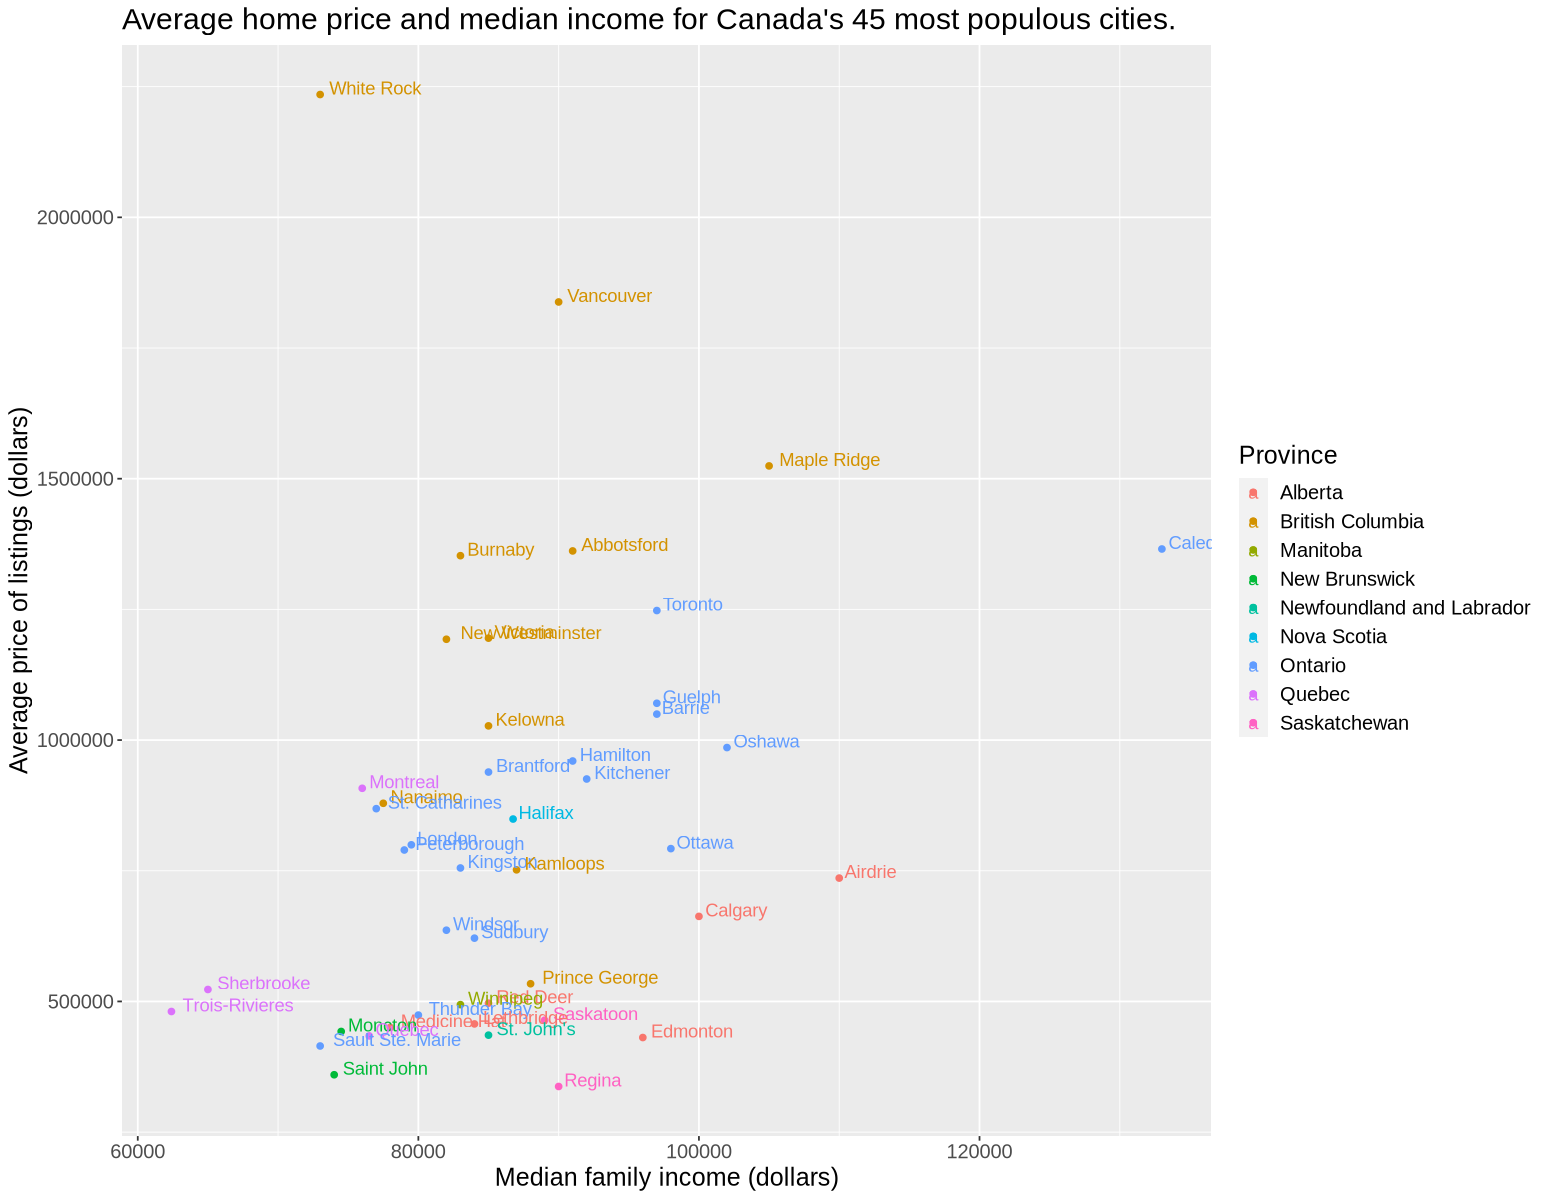

In [12]:
options(repr.plot.height = 10, repr.plot.width = 13)
housing_split <- initial_split(housing_clean, prop =0.8, strata = price)
housing_train <- training(housing_split)
housing_test <- testing(housing_split)



table_avg_price <- housing_train |>
group_by(city, province, median_family_income) |>
summarize(avg_price = mean(price), average_beds = mean(number_beds), average_baths = mean(number_baths)) |>
arrange(-avg_price)
table_avg_price


avg_price_plot <- ggplot(table_avg_price, aes(x = median_family_income, y = avg_price, color = province, label = city)) + geom_point() +
                labs(x = "Median family income (dollars)", y = "Average price of listings (dollars)", color = "Province",
                    title = "Average home price and median income for Canada's 45 most populous cities.") + geom_text(hjust = -0.1, vjust = 0) +
                theme(text = element_text(size = 15))
avg_price_plot

Although the graph looks a little messy, we've opted to leave labels on because it givees us a lot of information that we would otherwise have to comb through the table for. For example, White Rock, British Columbia could be considered the "least affordable" (for the average person) city, while Airdrie, Alberta would be the "most affordable" (for the average person). There is also a definite positive relationship between median family income, and average price.

We wanted to look at the nature of housing supply for each city, so we also measured the average number of beds, also the number of beds in  

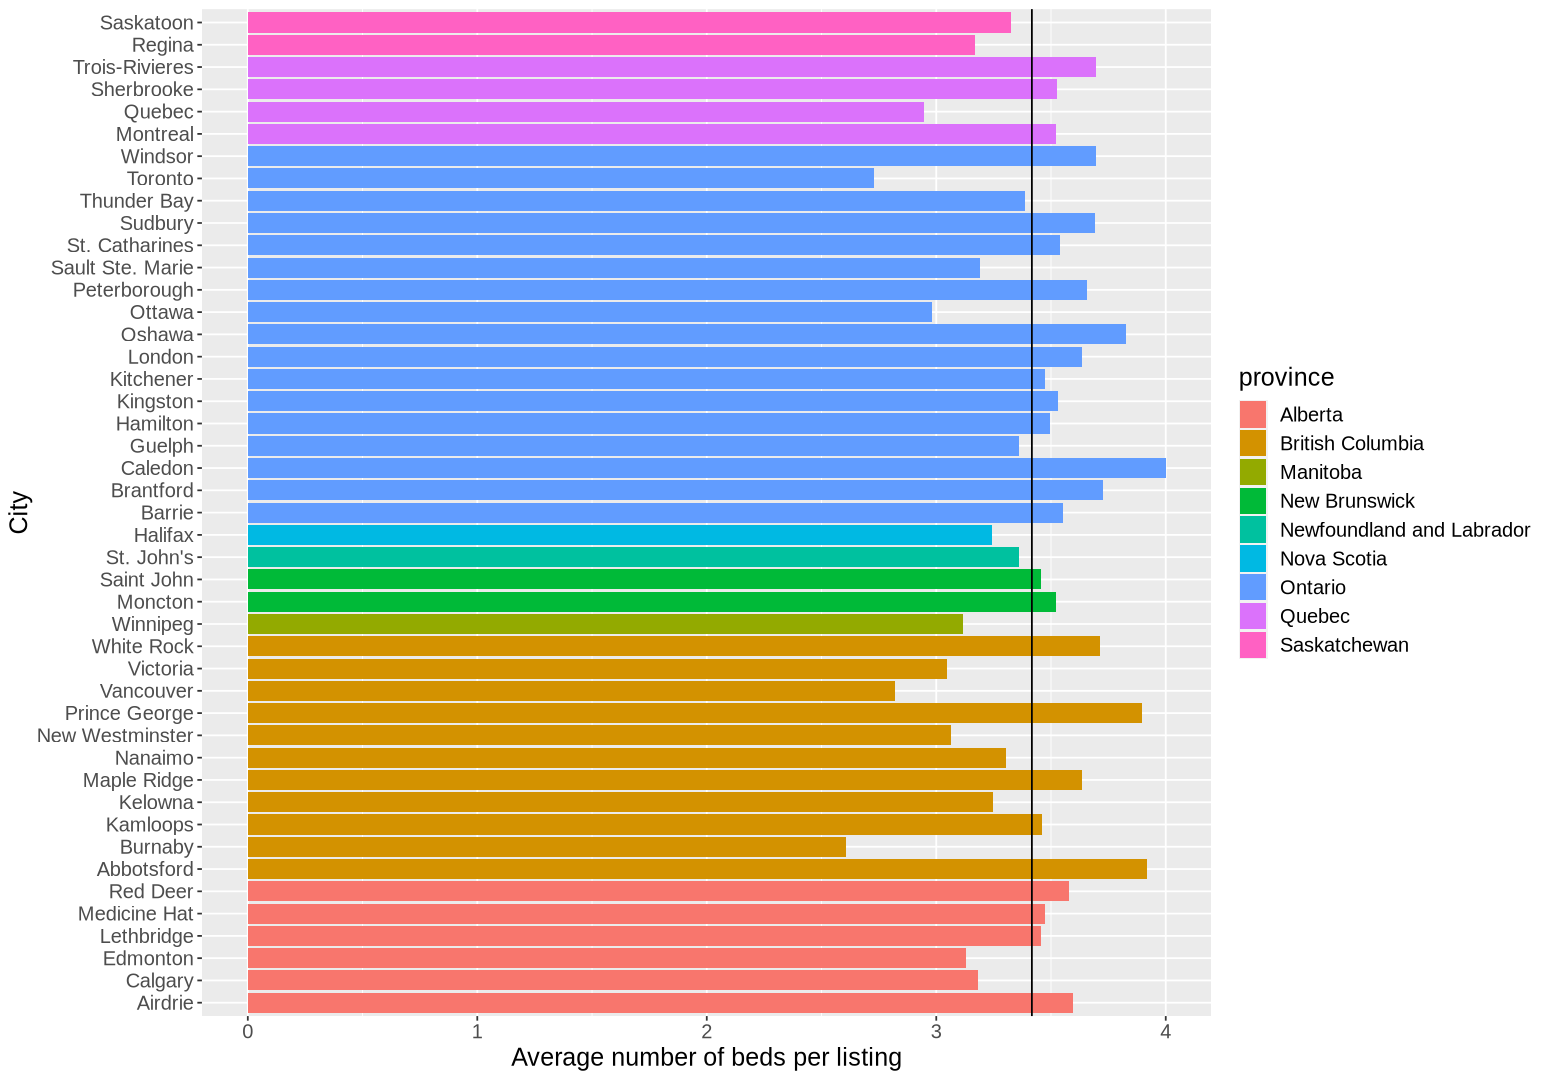

In [13]:
options(repr.plot.height = 9, repr.plot.width = 13)
average_bed_plot <- ggplot(table_avg_price, aes(y = fct_reorder(city, province), x = average_beds, fill = province)) +
                    geom_bar(stat = "identity") +
                    labs(x = "Average number of beds per listing", y = "City", color = "Province")+
                    geom_vline(xintercept = 3.416648)+
                    theme(text = element_text(size = 15))
average_bed_plot

We can now get ideas about which cities are more dense, and which ones are more suburban and have larger houses

`summarise()` has grouped output by 'city', 'Number_Beds_changed'. You can
override using the `.groups` argument.


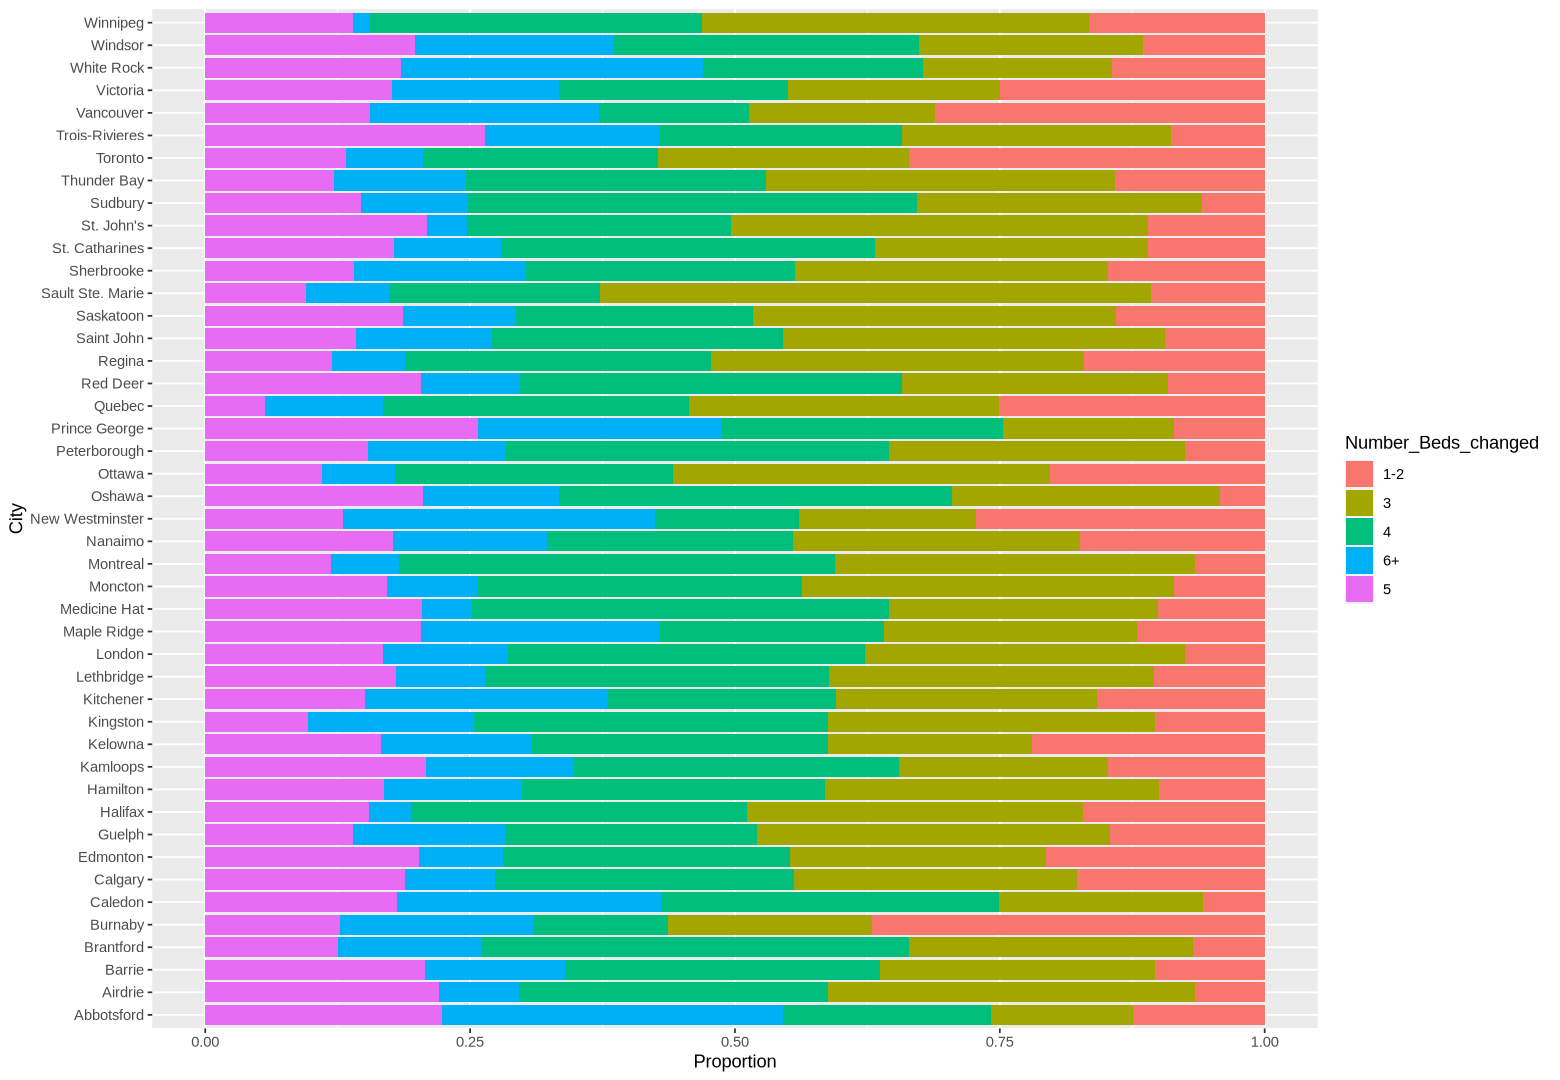

In [14]:
city <- housing_train |>
  mutate(Number_Beds_changed = case_when(
    number_beds <= 2 ~ "1-2" , 
    number_beds < 6 ~ as.character(number_beds),
    number_beds >= 6 ~ "6+")) |>
    mutate(Number_Beds_changed = as_factor(Number_Beds_changed))|> 
    group_by(city, Number_Beds_changed, number_beds)|>
    summarize(number_beds = sum(number_beds))

comparison <- city|>
              ggplot(aes(y= city, x= number_beds, fill = Number_Beds_changed))+
              geom_bar(stat = "identity", position = "fill")+
              labs(y = "City", x = "Proportion", color = "Number of beds")

comparison 

To get a better idea of the ditribution we made this bar chart, it seemed preferable to having a histogram for every city

## 3. Methods

We don't expect to see any meaningful corellation between address, latitude, longitude, and population with price, so we will be taking those out. It's also important to realize that median family income data is a column adding numeric value to city

In [15]:
housing_train_real <- housing_train |> select(-address, -latitude, -longitude, -population)
housing_train_real

city,price,number_beds,number_baths,province,median_family_income
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Toronto,439000,2,1,Ontario,97000
Toronto,438000,2,1,Ontario,97000
Toronto,399900,2,1,Ontario,97000
⋮,⋮,⋮,⋮,⋮,⋮
Halifax,6995000,4,5,Nova Scotia,86753
Halifax,1799900,5,3,Nova Scotia,86753
Halifax,6990000,5,5,Nova Scotia,86753


In order to visualize our results, we can create multiple scatter plots with the testing data. They will be price against number of beds, number of baths, and median family income. We can also plot the curve that represents our regression against each of these predictors.

## 4. Expected outcomes and significance

#### 1. What do you expect to find?
- We expect to find a positive correlation between median family income, number of
beds, and number of baths with housing prices in several Canadian cities.

- We would like to identify which factors seem to have a stronger influence on housing prices compared to others
  



#### 2. What impact could such findings have?
- Our findings could help people understand what factors and how much these factors contribute to housing costs
- Our findings could help buyers and sellers figure out what houses are underpriced and which ones are overpriced
- Understanding these factors could be important for influencing urban planners, developers,
  and real-estate investors, as well as buyers to make decisions about housing development, planning, and investing


#### What future questions could this lead to? 

 - Our study may lead to further questions about why certain factors have a stronger
influence on housing prices in Canadian cities compared to others
- Are there non-linear relationships between the predictors? For example, does the effect of adding an extra bedroom on housing price diminish at higher income levels?
- How do these relationships between median family income, number of beds/baths, and housing prices change over time? Are there any seasonal or longitudinal trends that could be looked into?